In [5]:
# # ================================================
# # Similar Product Search - Exercises 2 & 3
# # ================================================

# import pymongo
# from datasketch import MinHash, MinHashLSH
# from tqdm import tqdm
# import nltk
# from nltk.corpus import stopwords
# import math

# # -----------------------------
# # Download stopwords
# # -----------------------------
# nltk.download('stopwords')
# STOP_WORDS = set(stopwords.words('english'))

# # -----------------------------
# # MongoDB Setup
# # -----------------------------
# MONGO_URI = "mongodb://localhost:27017"
# DB_NAME = "cs5600"

# client = pymongo.MongoClient(MONGO_URI)
# db = client[DB_NAME]
# product_col = db["products"]
# signature_col = db["productsignatures"]

# # -----------------------------
# # Helpers
# # -----------------------------
# def remove_stopwords(text):
#     tokens = text.lower().split()
#     filtered = [t for t in tokens if t not in STOP_WORDS]
#     return " ".join(filtered)

# def get_text(product, mode):
#     """Return text string depending on mode"""
#     title = product.get("title", "") or ""
#     desc = " ".join(product.get("description", []) or [])
#     if mode == "pst":
#         return remove_stopwords(title)
#     elif mode == "psd":
#         return remove_stopwords(desc)
#     else:  # pstd
#         return remove_stopwords(title + " " + desc)

# def get_shingles(text, k):
#     """Convert text to word shingles of size k"""
#     tokens = text.lower().split()
#     return set([" ".join(tokens[i:i+k]) for i in range(len(tokens)-k+1)]) if len(tokens) >= k else set(tokens)

# def build_lsh(products, mode, shingle_size, num_perm, threshold):
#     """Build LSH index and MinHash signatures"""
#     lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)
#     sigs = {}
#     for p in products:
#         text = get_text(p, mode)
#         shingles = get_shingles(text, shingle_size)
#         m = MinHash(num_perm=num_perm)
#         for sh in shingles:
#             m.update(sh.encode("utf8"))
#         sigs[p["asin"]] = m
#         lsh.insert(p["asin"], m)
#     return lsh, sigs

# def precision_at_k(eval_products, mode, lsh, sigs, k=10):
#     """Compute precision@k"""
#     precisions = []
#     for p in eval_products:
#         asin = p["asin"]
#         gt = set(p.get("similar_asins", []))
#         if not gt:
#             continue
#         m = sigs[asin]
#         cands = lsh.query(m)
#         scored = [(c, m.jaccard(sigs[c])) for c in cands if c != asin]
#         top = [c for c, _ in sorted(scored, key=lambda x: -x[1])[:k]]
#         hit = len(gt.intersection(top))
#         precisions.append(hit / k)
#     return sum(precisions) / len(precisions) if precisions else 0

# # -----------------------------
# # Manual b,r calculation to skip r=1 or r>=4
# # -----------------------------
# def calc_b_r(num_perm, threshold):
#     """
#     Approximate b (bands) and r (rows per band) given num_perm and threshold.
#     Skip r=1 or r>=4.
#     """
#     for r in range(2, min(3, num_perm)+1):
#         b = num_perm // r
#         approx_thr = (1 / b)**(1 / r)  # rough approx
#         if approx_thr <= threshold:
#             return b, r
#     return None, None

# # -----------------------------
# # Exercise 3: Hyperparameter Tuning
# # -----------------------------
# def tune():
#     NUM_EVAL = 100
#     TOP_K = 10

#     # Build evaluation set (top-100 products with largest similar_asins)
#     eval_products = list(product_col.find(
#         {"similar_asins": {"$exists": True, "$not": {"$size": 0}}},
#         {"asin": 1, "title": 1, "description": 1, "similar_asins": 1}
#     ))
#     eval_products = sorted(eval_products, key=lambda x: len(x["similar_asins"]), reverse=True)[:NUM_EVAL]
#     eval_products = [p for p in eval_products if p.get("similar_asins")]
#     if not eval_products:
#         raise ValueError("No products with similar_asins found for evaluation set!")

#     max_size = max(len(p["similar_asins"]) for p in eval_products)
#     min_size = min(len(p["similar_asins"]) for p in eval_products)
#     print(f"Evaluation set: {len(eval_products)} products")
#     print(f"Max similar_asins: {max_size}, Min: {min_size}")

#     # Parameter grid
#     param_grid = {
#         "shingle_size": [2, 3, 4, 5],
#         "num_perm": [10, 20, 30, 50, 100, 150],
#         "threshold": [0.2, 0.3, 0.4, 0.5]
#     }

#     best_params = {}
#     for mode in ["pst", "psd", "pstd"]:
#         best = (0, None)
#         print(f"\n--- Tuning {mode} ---")
#         for shingle_size in param_grid["shingle_size"]:
#             for num_perm in param_grid["num_perm"]:
#                 for thr in param_grid["threshold"]:
#                     b, r = calc_b_r(num_perm, thr)
#                     if b is None or r is None:
#                         print(f"Skipping: shingle_size={shingle_size}, num_perm={num_perm}, threshold={thr} (invalid r)")
#                         continue

#                     lsh, sigs = build_lsh(eval_products, mode, shingle_size, num_perm, thr)
#                     score = precision_at_k(eval_products, mode, lsh, sigs, TOP_K)
                    
#                     # Print every combination
#                     print(f"shingle_size={shingle_size}, num_perm={num_perm}, threshold={thr}, b={b}, r={r}, precision@10={score:.4f}")
                    
#                     if score > best[0]:
#                         best = (score, (shingle_size, num_perm, thr))

#         if best[1] is None:
#             print(f"No valid parameter combination found for {mode}. Skipping.")
#             continue

#         best_params[mode] = {
#             "precision@10": best[0],
#             "shingle_size": best[1][0],
#             "num_perm": best[1][1],
#             "threshold": best[1][2]
#         }
#         print(f"\n✅ Best for {mode}: {best_params[mode]}")

#     return best_params


# # -----------------------------
# # Exercise 2: Full Precomputation
# # -----------------------------
# def precompute(best_params):
#     products = list(product_col.find({}, {"asin": 1, "title": 1, "description": 1}))
#     modes = ["pst", "psd", "pstd"]
#     TOP_K = 50

#     lsh_map, sig_map = {}, {}
#     for mode in modes:
#         if mode not in best_params:
#             print(f"Skipping {mode}, no best params found.")
#             continue
#         params = best_params[mode]
#         print(f"Building LSH for {mode} with params {params}")
#         lsh, sigs = build_lsh(products, mode, params["shingle_size"], params["num_perm"], params["threshold"])
#         lsh_map[mode] = lsh
#         sig_map[mode] = sigs

#     for p in tqdm(products, desc="Storing results"):
#         asin = p["asin"]
#         doc = {"asin": asin, "similar": {"pst": [], "psd": [], "pstd": []}}

#         for mode in modes:
#             if mode not in lsh_map:
#                 continue
#             m = sig_map[mode][asin]
#             candidates = lsh_map[mode].query(m)
#             scored = [(c, m.jaccard(sig_map[mode][c])) for c in candidates if c != asin]
#             top = [{"asin": c, "score": s} for c, s in sorted(scored, key=lambda x: -x[1])[:TOP_K]]
#             doc["similar"][mode] = top

#         signature_col.update_one({"asin": asin}, {"$set": doc}, upsert=True)

# # -----------------------------
# # Run Both Exercises
# # -----------------------------
# best = tune()           # Exercise 3: Hyperparameter tuning
# precompute(best)        # Exercise 2: Full precomputation
# print("✅ Done: stopwords removed, best params tuned, top-50 similar products stored.")


# ================================================
# Similar Product Search - PST, PSD, PSTD with ROUGE-L
# ================================================

# import pymongo
# from datasketch import MinHash, MinHashLSH
# from tqdm import tqdm
# import nltk
# from nltk.corpus import stopwords

# # -----------------------------
# # ROUGE-L function
# # -----------------------------
# def rouge_l_f1(pred, ref):
#     pred_tokens = pred.lower().split()
#     ref_tokens = ref.lower().split()
#     n, m = len(pred_tokens), len(ref_tokens)
#     dp = [[0]*(m+1) for _ in range(n+1)]
#     for i in range(n):
#         for j in range(m):
#             if pred_tokens[i] == ref_tokens[j]:
#                 dp[i+1][j+1] = dp[i][j]+1
#             else:
#                 dp[i+1][j+1] = max(dp[i][j+1], dp[i+1][j])
#     lcs = dp[n][m]
#     if lcs == 0:
#         return 0.0
#     prec = lcs / n
#     rec = lcs / m
#     f1 = (2*prec*rec)/(prec+rec) if (prec+rec) > 0 else 0.0
#     return f1

# # -----------------------------
# # Stopwords
# # -----------------------------
# nltk.download('stopwords')
# STOP_WORDS = set(stopwords.words('english'))

# # -----------------------------
# # MongoDB Setup
# # -----------------------------
# MONGO_URI = "mongodb://localhost:27017"
# DB_NAME = "cs5600"
# client = pymongo.MongoClient(MONGO_URI)
# db = client[DB_NAME]
# product_col = db["products"]
# signature_col = db["productsignatures"]

# # Drop old signatures
# result = signature_col.delete_many({})
# print(f"✅ Dropped {result.deleted_count} old signature documents.")

# # -----------------------------
# # Helpers
# # -----------------------------
# def remove_stopwords(text):
#     tokens = text.lower().split()
#     return " ".join([t for t in tokens if t not in STOP_WORDS])

# def get_text(product, mode):
#     title = product.get("title", "") or ""
#     desc = " ".join(product.get("description", []) or [])
#     if mode == "pst":
#         return title.lower()
#     elif mode == "psd":
#         return remove_stopwords(desc)
#     else:
#         return remove_stopwords(title + " " + desc)

# def get_shingles(text, k, mode):
#     if mode == "pst":
#         text = text.replace(" ", "")
#         return set([text[i:i+k] for i in range(len(text)-k+1)]) if len(text) >= k else set([text])
#     else:
#         tokens = text.split()
#         return set([" ".join(tokens[i:i+k]) for i in range(len(tokens)-k+1)]) if len(tokens) >= k else set(tokens)

# def build_lsh(products, mode, shingle_size, num_perm, threshold):
#     lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)
#     sigs = {}
#     for p in products:
#         text = get_text(p, mode)
#         if not text.strip():
#             continue
#         shingles = get_shingles(text, shingle_size, mode)
#         m = MinHash(num_perm=num_perm)
#         for sh in shingles:
#             m.update(sh.encode("utf8"))
#         sigs[p["asin"]] = m
#         lsh.insert(p["asin"], m)
#     return lsh, sigs

# # -----------------------------
# # Precision@k + ROUGE-L evaluation
# # -----------------------------
# def precision_at_k_rouge(eval_products, mode, lsh, sigs, products, k=10):
#     asin_to_product = {p["asin"]: p for p in products if "asin" in p}
#     precisions, rouges = [], []

#     for p in eval_products:
#         asin = p["asin"]
#         if asin not in sigs:
#             continue
#         m = sigs[asin]
#         cands = lsh.query(m)
#         scored = [(c, m.jaccard(sigs[c])) for c in cands if c in sigs and c != asin]
#         top = [c for c, _ in sorted(scored, key=lambda x: -x[1])[:k]]
#         gt_asins = set(p.get("similar_asins", []))
#         if not gt_asins:
#             continue

#         hits = sum(1 for c in top if c in gt_asins)
#         precisions.append(hits / k)

#         rouge_scores = []
#         for c in top:
#             pred_title = asin_to_product.get(c, {}).get("title", "")
#             rouge_c = max(
#                 (rouge_l_f1(pred_title, asin_to_product.get(gt, {}).get("title", "")) 
#                  for gt in gt_asins if gt in asin_to_product),
#                 default=0.0
#             )
#             rouge_scores.append(rouge_c)
#         rouges.append(sum(rouge_scores)/k if rouge_scores else 0.0)

#     return {
#         "precision@k": sum(precisions)/len(precisions) if precisions else 0.0,
#         "rouge_l": sum(rouges)/len(rouges) if rouges else 0.0
#     }

# # -----------------------------
# # Hyperparameter tuning
# # -----------------------------
# def tune():
#     NUM_EVAL = 100
#     TOP_K = 10
#     eval_products = list(product_col.find(
#         {"similar_asins": {"$exists": True, "$not": {"$size": 0}}},
#         {"asin": 1, "title": 1, "description": 1, "similar_asins": 1}
#     ))
#     eval_products = sorted(eval_products, key=lambda x: len(x["similar_asins"]), reverse=True)[:NUM_EVAL]
#     eval_products = [p for p in eval_products if p.get("similar_asins")]

#     products = list(product_col.find({}, {"asin":1,"title":1,"description":1}))

#     param_grid = {
#         "shingle_size": [2, 3, 5, 7],
#         "num_perm": [10, 20, 50, 100],
#         "threshold": [0.2, 0.3, 0.4, 0.5]
#     }

#     best_params = {}
#     for mode in ["pst", "psd", "pstd"]:
#         best_score = -1
#         best_config = None
#         print(f"\n--- Tuning {mode} ---")
#         for shingle_size in param_grid["shingle_size"]:
#             for num_perm in param_grid["num_perm"]:
#                 for thr in param_grid["threshold"]:
#                     lsh, sigs = build_lsh(eval_products, mode, shingle_size, num_perm, thr)
#                     if not sigs:
#                         continue
#                     res = precision_at_k_rouge(eval_products, mode, lsh, sigs, products, TOP_K)
#                     combined_score = 0.5*res["precision@k"] + 0.5*res["rouge_l"]
#                     print(f"shingle={shingle_size}, num_perm={num_perm}, thr={thr}, MAP@10={res['precision@k']:.4f}, ROUGE-L={res['rouge_l']:.4f}")
#                     if combined_score > best_score:
#                         best_score = combined_score
#                         best_config = {
#                             "shingle_size": shingle_size,
#                             "num_perm": num_perm,
#                             "threshold": thr,
#                             "MAP@10": res["precision@k"],
#                             "ROUGE-L": res["rouge_l"]
#                         }
#         best_params[mode] = best_config
#         print(f"\n✅ Best for {mode}: {best_config}")

#     return best_params, products, eval_products

# # -----------------------------
# # Precompute top-K similar products under `similar`
# # -----------------------------
# def precompute(best_params, products):
#     TOP_K = 10
#     for mode, params in best_params.items():
#         if not params:
#             continue
#         lsh, sigs = build_lsh(products, mode, params["shingle_size"], params["num_perm"], params["threshold"])
#         for p in tqdm(products, desc=f"Storing {mode} results"):
#             asin = p["asin"]
#             if asin not in sigs:
#                 continue
#             m = sigs[asin]
#             candidates = lsh.query(m)
#             scored = [(c, m.jaccard(sigs[c])) for c in candidates if c != asin]
#             top = [{"asin": c, "score": s} for c, s in sorted(scored, key=lambda x: -x[1])[:TOP_K]]

#             # ✅ Store inside `similar`
#             signature_col.update_one(
#                 {"asin": asin},
#                 {"$set": {f"similar.{mode}": top}},
#                 upsert=True
#             )

# # -----------------------------
# # Run pipeline
# # -----------------------------
# best_params, products, eval_products = tune()
# precompute(best_params, products)
# print("✅ Done: Best params tuned, top-10 similar products stored correctly under `similar` field.")




import pymongo
from datasketch import MinHash, MinHashLSH
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords

# -----------------------------
# ROUGE-L function
# -----------------------------
def rouge_l_f1(pred, ref):
    pred_tokens = pred.lower().split()
    ref_tokens = ref.lower().split()
    n, m = len(pred_tokens), len(ref_tokens)
    dp = [[0]*(m+1) for _ in range(n+1)]
    for i in range(n):
        for j in range(m):
            if pred_tokens[i] == ref_tokens[j]:
                dp[i+1][j+1] = dp[i][j]+1
            else:
                dp[i+1][j+1] = max(dp[i][j+1], dp[i+1][j])
    lcs = dp[n][m]
    if lcs == 0:
        return 0.0
    prec = lcs / n
    rec = lcs / m
    f1 = (2*prec*rec)/(prec+rec) if (prec+rec) > 0 else 0.0
    return f1

# -----------------------------
# Stopwords
# -----------------------------
nltk.download('stopwords')
STOP_WORDS = set(stopwords.words('english'))

# -----------------------------
# MongoDB Setup
# -----------------------------
MONGO_URI = "mongodb://localhost:27017"
DB_NAME = "cs5600"
client = pymongo.MongoClient(MONGO_URI)
db = client[DB_NAME]
product_col = db["products"]
signature_col = db["productsignatures"]

# Drop old signatures
result = signature_col.delete_many({})
print(f"✅ Dropped {result.deleted_count} old signature documents.")

# -----------------------------
# Helpers
# -----------------------------
def remove_stopwords(text):
    tokens = text.lower().split()
    return " ".join([t for t in tokens if t not in STOP_WORDS])

def get_text(product, mode):
    title = product.get("title", "") or ""
    desc = " ".join(product.get("description", []) or [])
    if mode == "pst":
        return title.lower()
    elif mode == "psd":
        return remove_stopwords(desc)
    else:
        return remove_stopwords(title + " " + desc)

def get_shingles(text, k, mode):
    if mode == "pst":
        text = text.replace(" ", "")
        return set([text[i:i+k] for i in range(len(text)-k+1)]) if len(text) >= k else set([text])
    else:
        tokens = text.split()
        return set([" ".join(tokens[i:i+k]) for i in range(len(tokens)-k+1)]) if len(tokens) >= k else set(tokens)

def build_lsh(products, mode, shingle_size, num_perm, threshold):
    lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)
    sigs = {}
    for p in products:
        text = get_text(p, mode)
        if not text.strip():
            continue
        shingles = get_shingles(text, shingle_size, mode)
        m = MinHash(num_perm=num_perm)
        for sh in shingles:
            m.update(sh.encode("utf8"))
        sigs[p["asin"]] = m
        lsh.insert(p["asin"], m)
    return lsh, sigs

# -----------------------------
# Precision@k + ROUGE-L evaluation
# -----------------------------
def precision_at_k_rouge(eval_products, mode, lsh, sigs, products, k=10):
    asin_to_product = {p["asin"]: p for p in products if "asin" in p}
    precisions, rouges = [], []

    for p in eval_products:
        asin = p["asin"]
        if asin not in sigs:
            continue
        m = sigs[asin]
        cands = lsh.query(m)
        scored = [(c, m.jaccard(sigs[c])) for c in cands if c in sigs and c != asin]
        top = [c for c, _ in sorted(scored, key=lambda x: -x[1])[:k]]
        gt_asins = set(p.get("similar_asins", []))
        if not gt_asins:
            continue

        hits = sum(1 for c in top if c in gt_asins)
        precisions.append(hits / k)

        rouge_scores = []
        for c in top:
            pred_title = asin_to_product.get(c, {}).get("title", "")
            rouge_c = max(
                (rouge_l_f1(pred_title, asin_to_product.get(gt, {}).get("title", "")) 
                 for gt in gt_asins if gt in asin_to_product),
                default=0.0
            )
            rouge_scores.append(rouge_c)
        rouges.append(sum(rouge_scores)/k if rouge_scores else 0.0)

    return {
        "precision@k": sum(precisions)/len(precisions) if precisions else 0.0,
        "rouge_l": sum(rouges)/len(rouges) if rouges else 0.0
    }

# -----------------------------
# Hyperparameter tuning
# -----------------------------
def tune():
    NUM_EVAL = 100
    TOP_K = 10
    eval_products = list(product_col.find(
        {"similar_asins": {"$exists": True, "$not": {"$size": 0}}},
        {"asin": 1, "title": 1, "description": 1, "similar_asins": 1}
    ))
    eval_products = sorted(eval_products, key=lambda x: len(x["similar_asins"]), reverse=True)[:NUM_EVAL]
    eval_products = [p for p in eval_products if p.get("similar_asins")]

    products = list(product_col.find({}, {"asin":1,"title":1,"description":1}))

    param_grid = {
        "shingle_size": [2, 3, 5, 7],
        "num_perm": [10, 20, 50, 100],
        "threshold": [0.2, 0.3, 0.4, 0.5]
    }

    import pandas as pd
    grid_results = []

    best_params = {}
    for mode in ["pst", "psd", "pstd"]:
        best_score = -1
        best_config = None
        print(f"\n--- Tuning {mode} ---")
        for shingle_size in param_grid["shingle_size"]:
            for num_perm in param_grid["num_perm"]:
                for thr in param_grid["threshold"]:
                    lsh, sigs = build_lsh(eval_products, mode, shingle_size, num_perm, thr)
                    if not sigs:
                        continue
                    res = precision_at_k_rouge(eval_products, mode, lsh, sigs, products, TOP_K)
                    combined_score = 0.5*res["precision@k"] + 0.5*res["rouge_l"]
                    grid_results.append({
                        "mode": mode,
                        "shingle_size": shingle_size,
                        "num_perm": num_perm,
                        "threshold": thr,
                        "precision@10": res["precision@k"],
                        "ROUGE-L": res["rouge_l"],
                        "MAP@10": res["precision@k"]
                    })
                    if combined_score > best_score:
                        best_score = combined_score
                        best_config = {
                            "shingle_size": shingle_size,
                            "num_perm": num_perm,
                            "threshold": thr,
                            "MAP@10": res["precision@k"],
                            "ROUGE-L": res["rouge_l"]
                        }
        best_params[mode] = best_config
        print(f"\n✅ Best for {mode}: {best_config}")

    # Save full grid
    df_grid = pd.DataFrame(grid_results)
    df_grid.to_csv("../data/hyperparam_fullgrid.csv", index=False)
    print("✅ Full hyperparameter grid saved to ../data/hyperparam_fullgrid.csv")
    return best_params, products, eval_products

# -----------------------------
# Precompute top-K similar products under `similar`
# -----------------------------
def precompute(best_params, products):
    TOP_K = 10
    for mode, params in best_params.items():
        if not params:
            continue
        lsh, sigs = build_lsh(products, mode, params["shingle_size"], params["num_perm"], params["threshold"])
        for p in tqdm(products, desc=f"Storing {mode} results"):
            asin = p["asin"]
            if asin not in sigs:
                continue
            m = sigs[asin]
            candidates = lsh.query(m)
            scored = [(c, m.jaccard(sigs[c])) for c in candidates if c != asin]
            top = [{"asin": c, "score": s} for c, s in sorted(scored, key=lambda x: -x[1])[:TOP_K]]

            signature_col.update_one(
                {"asin": asin},
                {"$set": {f"similar.{mode}": top}},
                upsert=True
            )

# -----------------------------
# Run pipeline
# -----------------------------
best_params, products, eval_products = tune()
precompute(best_params, products)
print("✅ Done: Best params tuned, top-10 similar products stored correctly under `similar` field.")


[nltk_data] Downloading package stopwords to /home/suvedh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✅ Dropped 30239 old signature documents.

--- Tuning pst ---

✅ Best for pst: {'shingle_size': 3, 'num_perm': 20, 'threshold': 0.2, 'MAP@10': 0.17300000000000001, 'ROUGE-L': 0.3433230728948465}

--- Tuning psd ---

✅ Best for psd: {'shingle_size': 2, 'num_perm': 10, 'threshold': 0.2, 'MAP@10': 0.06875, 'ROUGE-L': 0.12889089468115283}

--- Tuning pstd ---

✅ Best for pstd: {'shingle_size': 2, 'num_perm': 10, 'threshold': 0.2, 'MAP@10': 0.066, 'ROUGE-L': 0.1214330979350905}
✅ Full hyperparameter grid saved to ../data/hyperparam_fullgrid.csv


Storing pstd results: 100%|██████████| 30239/30239 [01:06<00:00, 455.64it/s] 

✅ Done: Best params tuned, top-10 similar products stored correctly under `similar` field.



--- PST Hyperparameter Results ---
    shingle_size  num_perm  threshold  precision@10   ROUGE-L  MAP@10
0              2        10        0.2         0.119  0.288835   0.119
1              2        10        0.3         0.085  0.190976   0.085
2              2        10        0.4         0.085  0.190976   0.085
3              2        10        0.5         0.044  0.066230   0.044
4              2        20        0.2         0.146  0.328540   0.146
..           ...       ...        ...           ...       ...     ...
59             7        50        0.5         0.001  0.005315   0.001
60             7       100        0.2         0.054  0.080176   0.054
61             7       100        0.3         0.014  0.020069   0.014
62             7       100        0.4         0.003  0.007315   0.003
63             7       100        0.5         0.001  0.005315   0.001

[64 rows x 6 columns]

--- PSD Hyperparameter Results ---
     shingle_size  num_perm  threshold  precision@10   ROUGE-L   

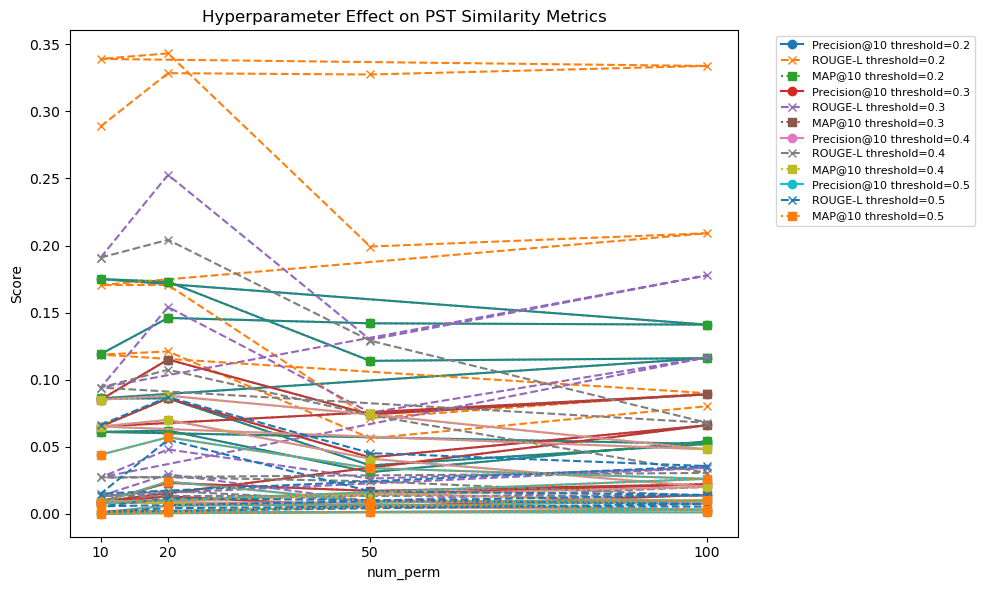

Saved plot: ../data/psd_hyperparam_plot.png


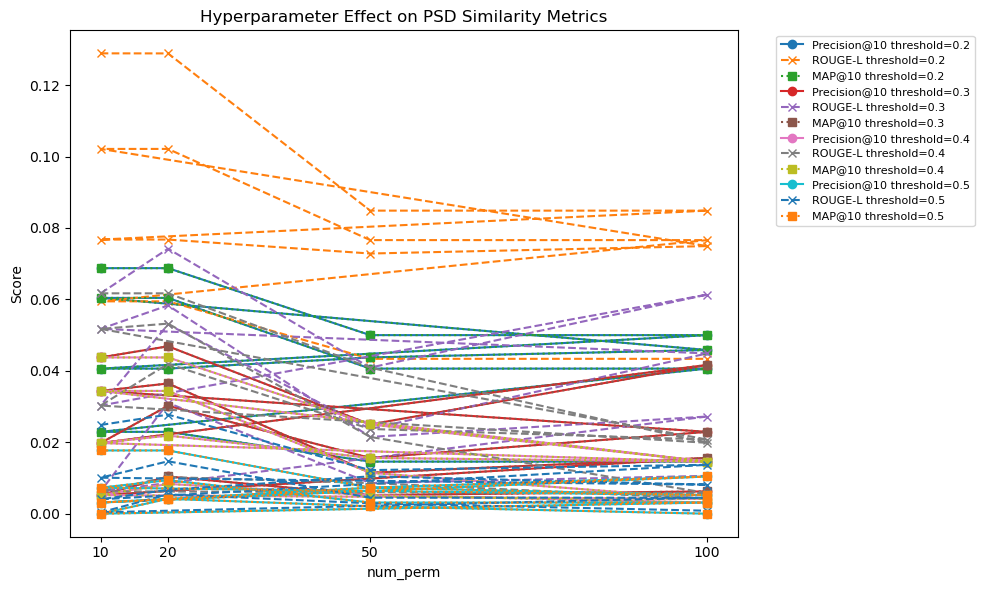

Saved plot: ../data/pstd_hyperparam_plot.png


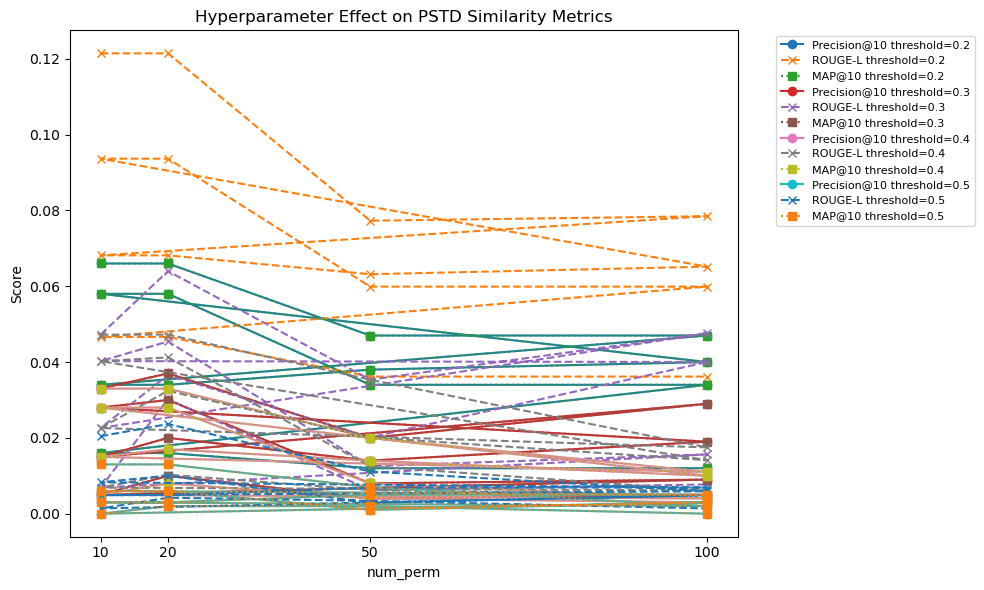

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# -----------------------------
# Load full grid results
# -----------------------------
csv_path = "../data/hyperparam_fullgrid.csv"
df = pd.read_csv(csv_path)

# Ensure output directory exists
os.makedirs("../data", exist_ok=True)

# -----------------------------
# Summary Table per mode
# -----------------------------
summary_tables = {}
for mode in df["mode"].unique():
    mode_df = df[df["mode"] == mode].copy()
    summary_tables[mode] = mode_df
    print(f"\n--- {mode.upper()} Hyperparameter Results ---")
    print(mode_df[["shingle_size","num_perm","threshold","precision@10","ROUGE-L","MAP@10"]])

# -----------------------------
# Plotting
# -----------------------------
for mode in df["mode"].unique():
    mode_df = df[df["mode"] == mode]
    
    fig, ax = plt.subplots(figsize=(10,6))
    for thr in sorted(mode_df["threshold"].unique()):
        subset = mode_df[mode_df["threshold"] == thr]
        label = f"threshold={thr}"
        ax.plot(subset["num_perm"], subset["precision@10"], marker='o', label=f"Precision@10 {label}")
        ax.plot(subset["num_perm"], subset["ROUGE-L"], marker='x', linestyle='--', label=f"ROUGE-L {label}")
        ax.plot(subset["num_perm"], subset["MAP@10"], marker='s', linestyle=':', label=f"MAP@10 {label}")
    
    ax.set_title(f"Hyperparameter Effect on {mode.upper()} Similarity Metrics")
    ax.set_xlabel("num_perm")
    ax.set_ylabel("Score")
    ax.set_xticks(sorted(mode_df["num_perm"].unique()))
    ax.legend(fontsize=8, bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    
    plot_path = f"../data/{mode}_hyperparam_plot.png"
    plt.savefig(plot_path)
    print(f"Saved plot: {plot_path}")
    plt.show()
